In [7]:
import spacy
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import randint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

In [2]:
class textPieces(): 
    def __init__(self, author, sample=True, pieces=2): 
        self.author = author
        self.filenames = glob('data/%s*' % author)
        #print('Using filenames: ', self.filenames)
        self.texts = [open(filename, errors="ignore").read() 
                 for filename in self.filenames]
        self.lengths = [len(text) for text in self.texts]
        self.lowestLength = min(self.lengths)
        if sample: 
            self.samples = [self.sample(text) for text in self.texts]
        else: 
            self.samples = self.texts
        if pieces > 1: 
            self.labels = []
            self.pieces = []
            self.makePieces(self.filenames, self.samples, 2)
        else: 
            self.labels = [filename[6+len(self.author):-4] for filename in self.filenames]
            self.pieces = self.texts
        
    def sample(self, text): 
        """ Randomly samples from texts that are long, 
        so that we're comparing the same amount of text across documents."""
        chunkSize = self.lowestLength
        # We want a chunk of [a:b] where the max value of b is end-chunkSize
        textLength = len(text)
        maxEnd = textLength - chunkSize
        if maxEnd <= 0: 
            #print('Something went wrong. maxEnd is negative or zero.')
            return text
        start = randint(0, maxEnd)
        return text[start:start+chunkSize]
    
    def makePieces(self, filenames, samples, n): 
        pieceSize = self.lowestLength / n
        for filename, sample in zip(filenames, samples): 
            for i in range(n):
                label = filename[6+len(self.author):-4] # Cut off 'data/cather-' for example and .txt
                pieceLabel = "%s-%s" % (label, i)
                start = int(i*pieceSize)
                end = int(start+pieceSize)
#                 print('Piece start: %s, piece end: %s' % (start, end))
                piece = sample[start:end]
                self.labels.append(pieceLabel)
                self.pieces.append(piece)

In [3]:
class authorAnalysis(): 
    def __init__(self, labels, docs): 
        self.labels = labels
        self.docs = docs
        self.features, self.matrix = self.vectorize()
        # Assume the date is the first four characters of the label. 
        self.pieceDates = [int(label[:4]) for label in self.labels]
        # Try to assign "early," "middle," and "late" categories (0, 1, 2) based on years. 
        self.categories = [round(cat) for cat in self.rescale(self.pieceDates, 0, 2)]
        
    #@property
    #def categories(): 
    #    pass
        
    def vectorize(self): 
        tfidf = TfidfVectorizer(use_idf=False, max_features=800)
        matrix = tfidf.fit_transform(self.docs).todense()
        features = tfidf.get_feature_names()
        return features, matrix
    
    def vectorDF(self):
        """ Just a helper to visualize the TFIDF table."""
        return pd.DataFrame(self.matrix, columns=self.features, index=self.labels)
    
    def doPCA(self): 
        pca = PCA(n_components=5)
        return pca.fit_transform(self.matrix)
    
    def doTSNE(self): 
        tSNE = TSNE(n_components=2)
        return tSNE.fit_transform(self.matrix)
        
    def plotPCA(self, tSNE=False, labels=True, saveTo=False, clustering='bgm'): 
        if tSNE: 
            pcaTable = self.doTSNE()
        else: 
            pcaTable = self.doPCA()
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        #df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        df['distance'] = df.apply(np.linalg.norm, axis=1)
        if clustering == 'kmeans': 
            colors = self.kmeans()
        if clustering == 'bgm': 
            colors = self.bgm()
        df['bgm'] = self.bgm()
        df['initCats'] = self.categories
        df['pubDate'] = self.pieceDates
        ax = plt.scatter(df[0], df[1], s=self.size, c=colors)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('results/pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False)
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    def kmeans(self): 
        pcaOut = self.doPCA()
        kmeans = KMeans(n_clusters=3)
        return kmeans.fit_predict(pcaOut)
    
    def bgm(self): 
        pcaOut = self.doPCA()
        bgm = BayesianGaussianMixture(n_components=3).fit(pcaOut)
        return bgm.predict(pcaOut)
        
    def lateCatEarlyCat(self): 
        """ Find the bgm-predicted category with the latest works, and the earliest."""
        catsDict = {} # Contains total dates per initial category
        for i in range(3):
            # Sum all the dates
            catsDict[i] = df.loc[df['bgm'] == i]['pubDate'].mean()
        #print(catsDict)
        return max(catsDict, key=catsDict.get), min(catsDict, key=catsDict.get)
    
    def metrics(self): 
        randK = adjusted_rand_score(self.categories, self.kmeans())
        randB = adjusted_rand_score(self.categories, self.bgm())
        #print('Adjusted rand score, Kmeans: ', randK)
        print('Periodicity: Adjusted rand score, BGM: ', randB)
        randK = adjusted_mutual_info_score(self.categories, self.kmeans())
        randB = adjusted_mutual_info_score(self.categories, self.bgm())
        #print('Adjusted mutual info score, Kmeans: ', randK)
        #print('Adjusted mutual info score, BGM: ', randB)
        print('Lateness: ', self.lateness())
        #print('TDD-Lateness: ', self.tddLateness())
        
    def periodicity(self): 
        return adjusted_rand_score(self.categories, self.bgm())
    
    def categorize(self, cats):
        pointsDict = {cat: [] for cat in set(cats)}
        for point, cat in zip(self.doPCA(), cats):
            pointsDict[cat].append(point)
        return pointsDict
                              
    def categorizeBGM(self):
        return self.categorize(self.bgm())
    
    def categorizePoints(self):
        return self.categorize(self.categories)
    
    def categorizeTdd(self):
        return self.categorize(self.tddCats)
    
    def centroids(self, cats): 
        centroidsDict = {}
        for key, val in cats.items():
            centroid = np.mean(val, axis=0)
            centroidsDict[key] = centroid
        return centroidsDict
    
    def centroidsBGM(self): 
        return self.centroids(self.categorizeBGM())
    
    def centroidsCats(self): 
        #print('categorized points: ', self.categorizePoints())
        return self.centroids(self.categorizePoints())
        
    def centroidsTddCats(self):
        return self.centroids(self.categorizeTdd())
    
    def lateDistinctiveness(self): 
        #lateCat = self.lateCatEarlyCat()[0]
        return np.linalg.norm(self.centroidsCats()[2])
    
    def earlyDistinctiveness(self):
        #earlyCat = self.lateCatEarlyCat()[1]
        #print(self.centroidsCats())
        #print(self.bgm())
        return np.linalg.norm(self.centroidsCats()[0])
    
    def lateness(self):
        return self.lateDistinctiveness() - self.earlyDistinctiveness()
    
    def lateDistinctivenessTdd(self):
        if 2 in self.centroidsTddCats(): 
            return np.linalg.norm(self.centroidsTddCats()[2])
        else:
            return 0
    
    def earlyDistinctivenessTdd(self):
        if 0 in self.centroidsTddCats():
            return np.linalg.norm(self.centroidsTddCats()[0])
        else:
            return 0
    
    def tddLateness(self):
        return self.lateDistinctivenessTdd() - self.earlyDistinctivenessTdd()

In [4]:
authorTable = {}

In [5]:
def doAnalysis(author, nIterations=10):  
    latenesses = []
    periodicities = []
    print('Lateness: ')
    for i in range(nIterations): 
        pieces = textPieces(author)
        analysis = authorAnalysis(pieces.labels, pieces.pieces)
        print('{}: {}'.format(i, analysis.lateness()), end=' ')
        latenesses.append(analysis.lateness())
        periodicities.append(analysis.periodicity())
    df = analysis.plotPCA(saveTo=author)
    print()
    print(analysis.metrics())
    averageLateness = sum(latenesses)/len(latenesses)
    print('Average lateness: ', averageLateness)
    averagePeriodicity = sum(periodicities)/len(periodicities)
    print('Average periodicities: ', averagePeriodicity)
    #latecat, earlycat = analysis.lateCatEarlyCat()
    #print("Latecat: {}, earlycat: {}".format(latecat, earlycat))
    authorTable[author] = {'mean lateness': averageLateness, 'mean periodicity': averagePeriodicity}
    return df

# Proust

Lateness: 
0: -0.09087608644691639 1: -0.05596513077621411 2: -0.1081682559753073 3: -0.10974749493135277 4: -0.10657886015912943 5: -0.10931226673815246 6: -0.04829887558834693 7: -0.11067426097073595 8: -0.08736382972461967 9: -0.03993106412897539 
Periodicity: Adjusted rand score, BGM:  0.19182948490230903
Lateness:  -0.039931064128975305
None
Average lateness:  -0.08669161254397507
Average periodicities:  0.04289012547737651


,0,1,2,3,4,distance,bgm,initCats,pubDate
1925-albertine-0,0.216563,-0.029353,-0.008380,0.040940,-0.005243,0.222564,2,2,1925
1913-swann-1,-0.087519,-0.030594,0.094942,0.106483,0.006316,0.170259,1,0,1913
1927-retrouve-1,0.003871,0.109728,-0.068735,0.027184,0.026295,0.134945,0,2,1927
1913-swann-0,-0.022750,0.096017,0.060640,-0.024438,-0.055846,0.130882,0,0,1913
1927-retrouve-0,-0.092028,0.015927,-0.078903,0.033713,0.003291,0.126870,1,2,1927
1921-sodome-1,-0.079039,-0.055995,-0.038020,-0.020869,-0.046133,0.115723,2,1,1921
1921-sodome-0,-0.063019,-0.086501,-0.025479,-0.027023,-0.003343,0.113333,2,1,1921
1920-guermantes-0,-0.043179,-0.025914,0.038119,-0.053392,0.069420,0.107976,2,1,1920
1923-prisonniere-1,0.043841,-0.082748,-0.022558,-0.014380,-0.009514,0.097854,2,1,1923
1919-lombre-0,0.065023,0.052663,0.023323,-0.038626,-0.007290,0.095344,2,1,1919


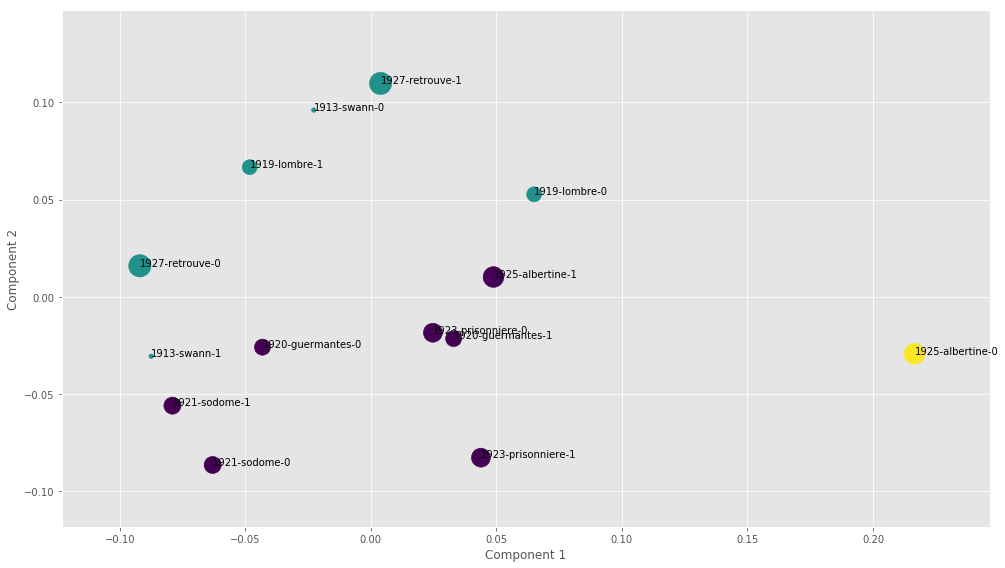

In [80]:
doAnalysis('proust')

# Dickens

Lateness: 
0: 0.01707893465500336 1: 0.009818878629561226 2: 0.014587216093697744 3: 0.008964126456836766 4: 0.013446370225841164 5: -0.006413654245480349 6: 0.003172992012576578 7: 0.016672670964302735 8: 0.00887755814249204 9: -0.003951035191977606 
Periodicity: Adjusted rand score, BGM:  0.31010731278145004
Lateness:  -0.00395056929414464
None
Average lateness:  0.008225205781793676
Average periodicities:  0.2282231294470038


,0,1,2,3,4,distance,bgm,initCats,pubDate
1837-the-pickwick-papers-0,0.231470,0.073756,0.095186,-0.005221,-0.021319,0.261840,2,0,1837
1837-the-pickwick-papers-1,0.175112,0.140590,0.107574,-0.015964,0.007146,0.249615,2,0,1837
1850-david-copperfield-1,-0.179752,-0.023780,0.106817,-0.039758,-0.003489,0.214194,0,1,1850
1839-oliver-twist-0,0.195949,0.042776,0.005943,-0.044216,0.025381,0.207027,2,0,1839
1850-david-copperfield-0,-0.165847,-0.043762,0.092064,-0.063420,0.015671,0.205338,0,1,1850
1853-bleak-house-1,-0.168345,0.061307,-0.021326,0.058846,-0.076791,0.204727,1,1,1853
1861-great-expectations-0,-0.104291,-0.090440,0.071321,-0.098219,-0.070947,0.197036,0,1,1861
1848-dombey-and-son-1,-0.034960,-0.082707,0.059372,0.158539,0.008386,0.191814,2,1,1848
1853-bleak-house-0,-0.135982,0.065784,-0.050677,-0.000397,-0.078136,0.177461,1,1,1853
1839-oliver-twist-1,0.165690,0.001138,-0.005313,-0.015547,0.006854,0.166647,2,0,1839


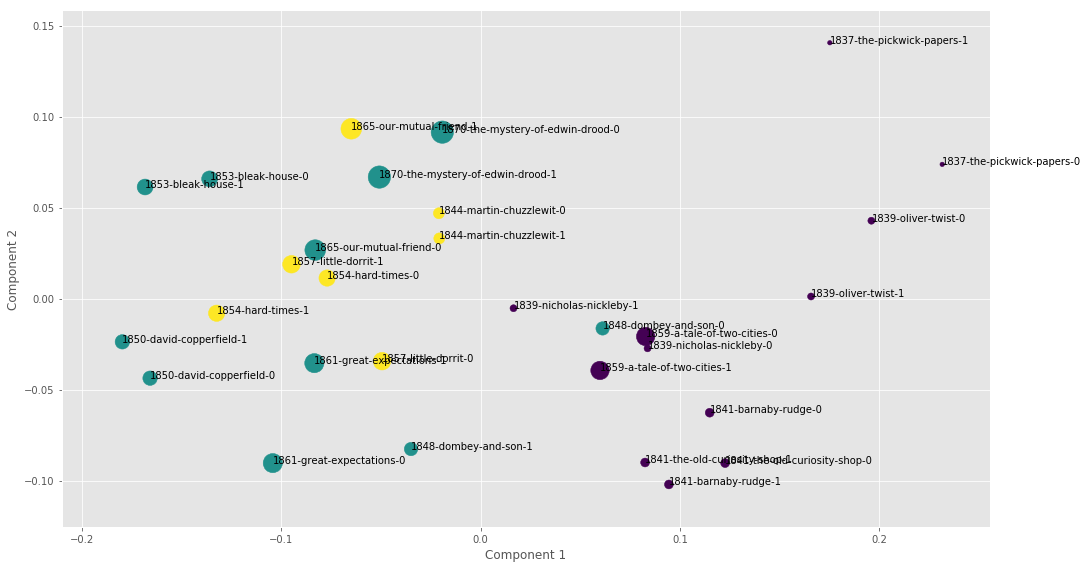

In [81]:
doAnalysis('dickens')

# Conrad

Lateness: 
0: 0.005077196508396928 1: -0.00809676676308646 2: 0.017740662226371634 3: 0.02368757065265263 4: 0.009751067953497644 5: 0.008439272582126914 6: 0.014281918745547267 7: 0.014413840569671738 8: 0.026450208083685603 9: 9.136303206315477e-05 
Periodicity: Adjusted rand score, BGM:  0.06171802657363741
Lateness:  8.972510136645573e-05
None
Average lateness:  0.011183377441169927
Average periodicities:  0.09272393387208157


,0,1,2,3,4,distance,bgm,initCats,pubDate
1919-the-arrow-of-gold-1,0.323366,0.032514,0.084841,0.076497,-0.006186,0.344544,0,2,1919
1919-the-arrow-of-gold-0,0.274510,0.108213,0.054361,0.121578,0.022063,0.324483,0,2,1919
1907-the-secret-agent-1,0.047600,0.141684,-0.142213,-0.017399,0.144279,0.252357,2,1,1907
1897-the-nigger-of-the-narcissus-0,-0.175718,0.028638,0.147318,0.056586,0.074299,0.249243,1,0,1897
1895-almayers-folly-1,-0.070489,0.165339,0.121279,-0.027918,-0.036297,0.221611,1,0,1895
1895-almayers-folly-0,-0.180525,0.105282,0.031536,-0.024447,-0.027563,0.214536,1,0,1895
1907-the-secret-agent-0,-0.007683,0.112030,-0.101932,-0.057748,0.126661,0.205858,2,1,1907
1896-an-outcast-of-the-islands-0,0.057329,-0.030787,0.143010,-0.091954,0.036475,0.185667,2,0,1896
1913-chance-1,0.165595,0.022008,-0.022895,-0.069583,0.019618,0.183458,0,1,1913
1900-lord-jim-1,0.024391,-0.159291,0.025106,-0.040256,0.059745,0.178295,2,0,1900


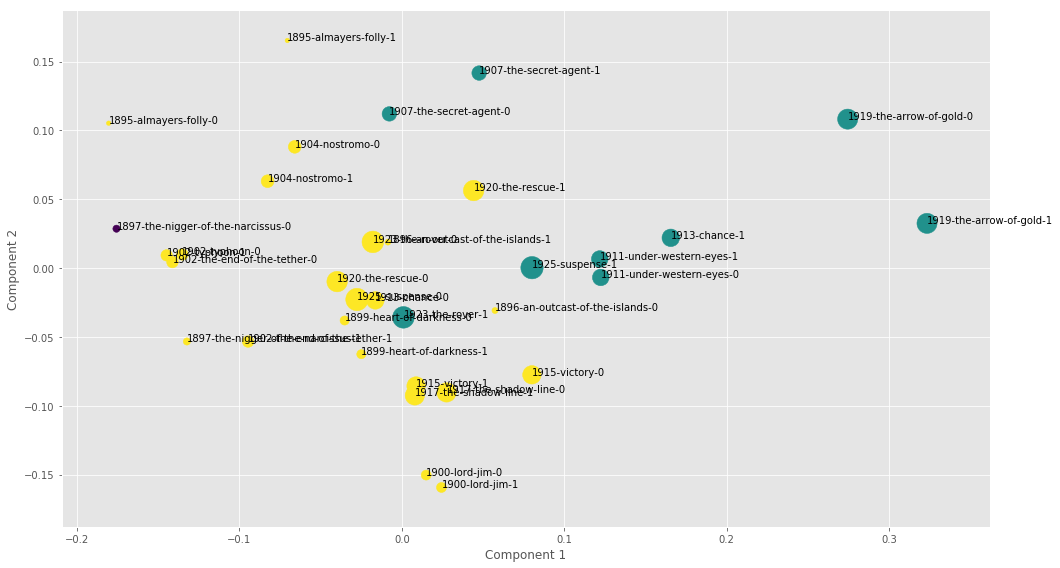

In [82]:
doAnalysis('conrad') 

# Jean Genet

Lateness: 
0: 0.14753879898613187 1: 0.16058158559179975 2: 0.15308161514571686 3: 0.1450374405495449 4: 0.1733775574297272 5: 0.15213391782258703 6: 0.14873573437337453 7: 0.14751560647989528 8: 0.15715676982053722 9: 0.1407575018130868 
Periodicity: Adjusted rand score, BGM:  -0.1702127659574469
Lateness:  0.14075750181308685
None
Average lateness:  0.15259165280124015
Average periodicities:  0.13604806408544726


,0,1,2,3,4,distance,bgm,initCats,pubDate
1947-querelle-de-brest-1,0.198895,-0.116891,-0.066043,-0.055725,-0.030479,0.248231,1,0,1947
1947-querelle-de-brest-0,0.201739,-0.054661,-0.048747,0.006664,0.015902,0.215314,1,0,1947
1949-journal-du-voleur-1,-0.146688,-0.128128,0.020869,-0.035375,-0.051104,0.205506,0,0,1949
1949-journal-du-voleur-0,-0.182828,-0.065441,0.007563,0.010537,-0.052313,0.201528,0,0,1949
1986-captif-amoreux-0,-0.048258,0.144992,-0.091256,0.014422,0.001537,0.178576,2,2,1986
1986-captif-amoreux-1,-0.083083,0.125478,-0.086914,0.013817,-0.031239,0.177112,2,2,1986
1942-notre-dame-1,0.089905,0.120488,0.081540,-0.041917,-0.015383,0.176756,2,0,1942
1942-notre-dame-0,0.071244,0.107043,0.101295,-0.028969,-0.024045,0.167965,2,0,1942
1946-miracle-de-la-rose-0,-0.113893,-0.028686,0.009502,-0.046861,0.080595,0.150254,0,0,1946
1947-pompes-funèbres-0,0.022790,-0.067096,0.046239,0.093441,-0.001158,0.126063,1,0,1947


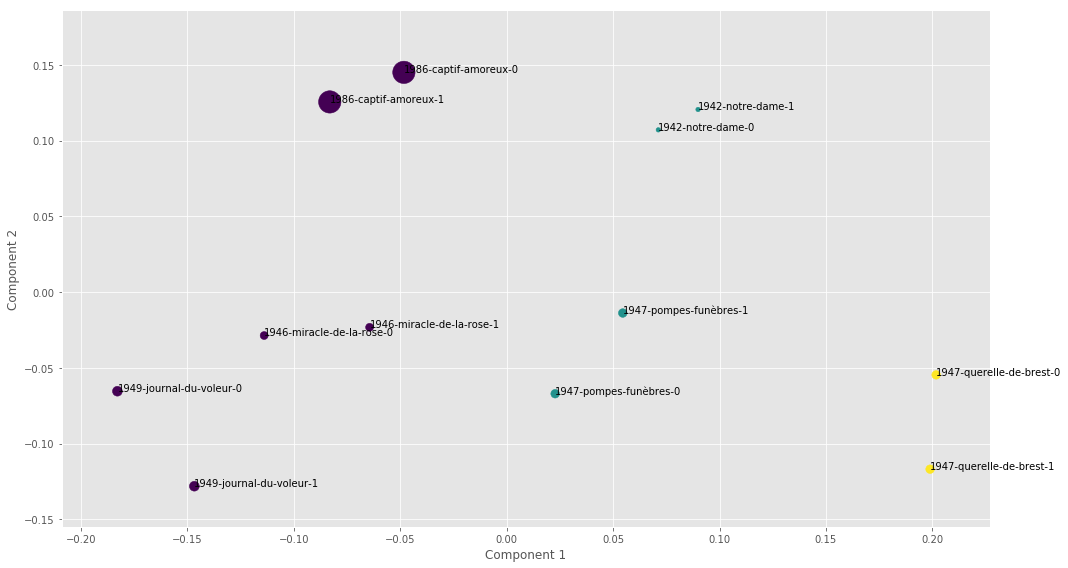

In [83]:
doAnalysis('genet')

# James

Lateness: 
0: 0.05440071566374306 1: 0.06646304646134653 2: 0.0627568689779691 3: 0.06644907768729923 4: 0.06456570490945307 5: 0.053664947944604705 6: 0.0586716655249286 7: 0.052179947386223974 8: 0.06617061965063092 9: 0.06589275548503622 
Periodicity: Adjusted rand score, BGM:  0.09961787496019535
Lateness:  0.06592284923645947
None
Average lateness:  0.06111971825484062
Average periodicities:  0.2858349875647828


,0,1,2,3,4,distance,bgm,initCats,pubDate
1903-ambassadors-0,-0.072598,0.234977,-0.096384,-0.018152,0.102941,0.284079,2,1,1903
1901-sacred-found-1,-0.013084,0.009981,0.246875,0.118398,0.058483,0.280457,2,1,1901
1901-sacred-found-0,0.111862,0.119484,0.114314,0.163209,0.003316,0.257887,0,1,1901
1877-the-american-1,-0.139779,-0.161736,-0.022484,0.099759,-0.075544,0.248718,1,0,1877
1880-washington-square-1,0.008149,-0.218261,0.027262,-0.022890,0.110569,0.247380,1,0,1880
1917-ivory-tower-1,-0.138933,0.173092,0.068055,0.060477,-0.054249,0.245957,2,2,1917
1911-outcry-1,-0.182667,0.077073,0.114289,-0.085726,-0.026385,0.245794,2,2,1911
1875-roderick-hudson-0,-0.126257,0.072583,-0.190357,0.019615,-0.017661,0.241126,1,0,1875
1897-spoils-poynton-1,0.150303,-0.135503,0.110136,-0.043952,0.045495,0.238922,0,1,1897
1877-the-american-0,-0.183903,-0.094143,-0.062595,0.100032,0.009594,0.238118,1,0,1877


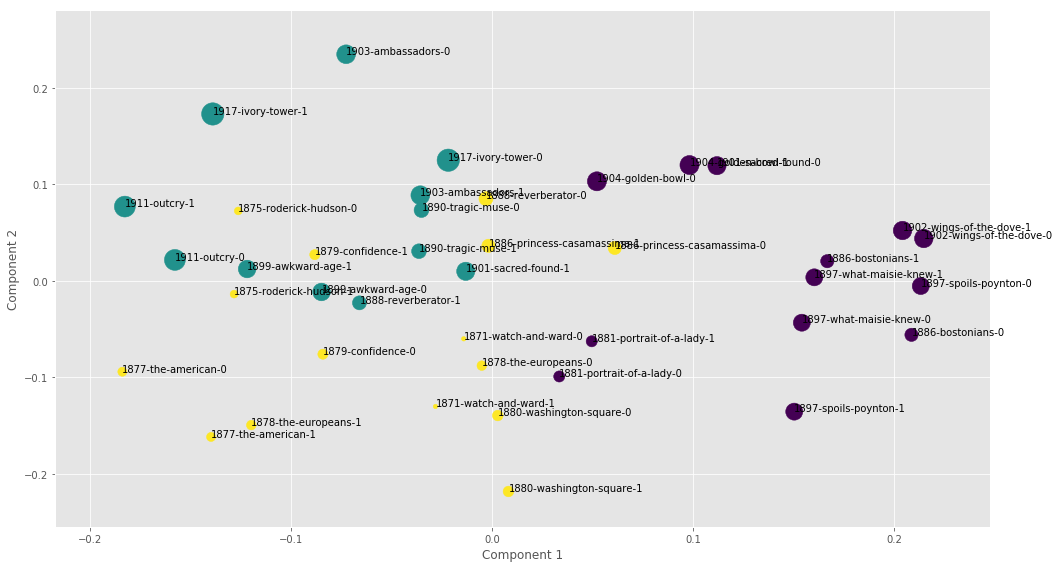

In [84]:
doAnalysis('james')

# Mann

Lateness: 
0: 0.1649550470702669 1: 0.1565612311826663 2: 0.1354422316856589 3: 0.18776742047446981 4: 0.18107149831513236 5: 0.2381178185191396 6: 0.28020108224129237 7: 0.15035010325082476 8: 0.25111875007834955 9: 0.22552326872649092 
Periodicity: Adjusted rand score, BGM:  0.1433566433566434
Lateness:  0.225523268726491
None
Average lateness:  0.19711084515442906
Average periodicities:  0.07703710536937572


,0,1,2,3,4,distance,bgm,initCats,pubDate
1909-königliche-1,0.358772,-0.046021,-0.108809,0.144562,0.011438,0.404603,2,1,1909
1897-kleine-herr-1,0.148278,0.203725,0.278193,0.084447,-0.034101,0.386233,1,0,1897
1903-tristan-1,0.312086,-0.020129,-0.121613,-0.043308,-0.047448,0.341643,2,0,1903
1943-doktor-0,-0.140209,0.271181,-0.066451,0.009282,0.039536,0.315060,1,2,1943
1912-tod-0,-0.289499,-0.072268,-0.016488,0.069360,-0.065560,0.313709,0,1,1912
1912-tod-1,-0.286162,-0.036649,-0.048236,0.029337,-0.100257,0.310597,0,1,1912
1943-doktor-1,-0.186468,0.236721,-0.050377,0.015041,0.034987,0.307888,1,2,1943
1903-tonio-1,0.220862,0.100399,-0.041921,-0.154885,-0.020133,0.291568,2,0,1903
1909-königliche-0,0.001104,-0.075456,-0.077362,0.178973,0.170676,0.269891,0,1,1909
1901-buddenbrooks-1,-0.006203,-0.089753,0.186338,-0.093208,0.134915,0.264019,0,0,1901


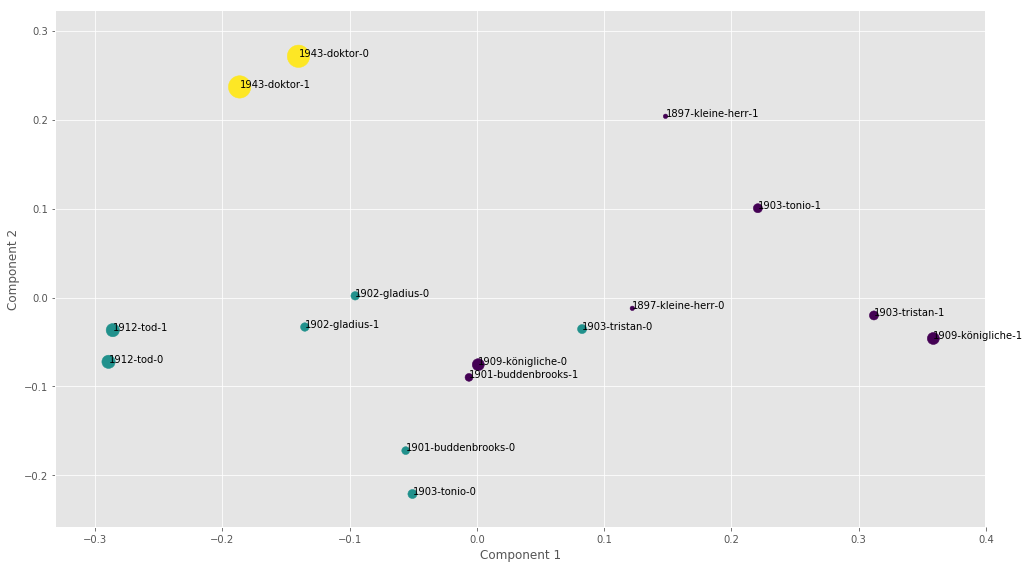

In [85]:
doAnalysis('mann')

# Scott

Lateness: 
0: 0.02106427480574078 1: 0.024320119475500952 2: 0.036571568035174064 3: 0.02662283864924106 4: 0.016389577349660178 5: 0.023027932216217045 6: 0.02067446918816168 7: 0.021880192020427985 8: 0.027689018362175986 9: 0.029523742869568964 
Periodicity: Adjusted rand score, BGM:  -0.03665131427043709
Lateness:  0.029526921486231233
None
Average lateness:  0.024776815007941773
Average periodicities:  0.07635529162513488


,0,1,2,3,4,distance,bgm,initCats,pubDate
1818-heart-of-midlothian-0,0.167431,0.165504,0.069216,-0.033195,-0.016192,0.248152,2,0,1818
1823-st-ronans-well-1,0.197887,-0.035046,-0.077198,-0.027530,-0.020591,0.218011,1,1,1823
1817-rob-roy-1,0.093190,-0.052404,0.143885,0.026567,0.096647,0.205377,2,0,1817
1823-st-ronans-well-0,0.144964,-0.077734,-0.061582,-0.041317,0.022024,0.181773,1,1,1823
1818-heart-of-midlothian-1,0.099536,0.108036,0.032548,-0.049830,-0.046763,0.165252,2,0,1818
1829-anne-1,-0.154982,0.010590,0.023176,-0.032712,0.000617,0.160434,0,2,1829
1831-castle-dangerous-1,-0.020878,0.030055,-0.102646,-0.101142,0.037987,0.153454,0,2,1831
1820-the-abbot-1,0.027028,0.127665,-0.046664,0.037090,0.023018,0.145300,2,1,1820
1832-count-robert-0,-0.131272,0.017793,-0.032876,-0.042770,0.022630,0.144815,0,2,1832
1816-antiquary-1,0.128330,-0.047945,0.015643,0.028071,0.026681,0.143219,0,0,1816


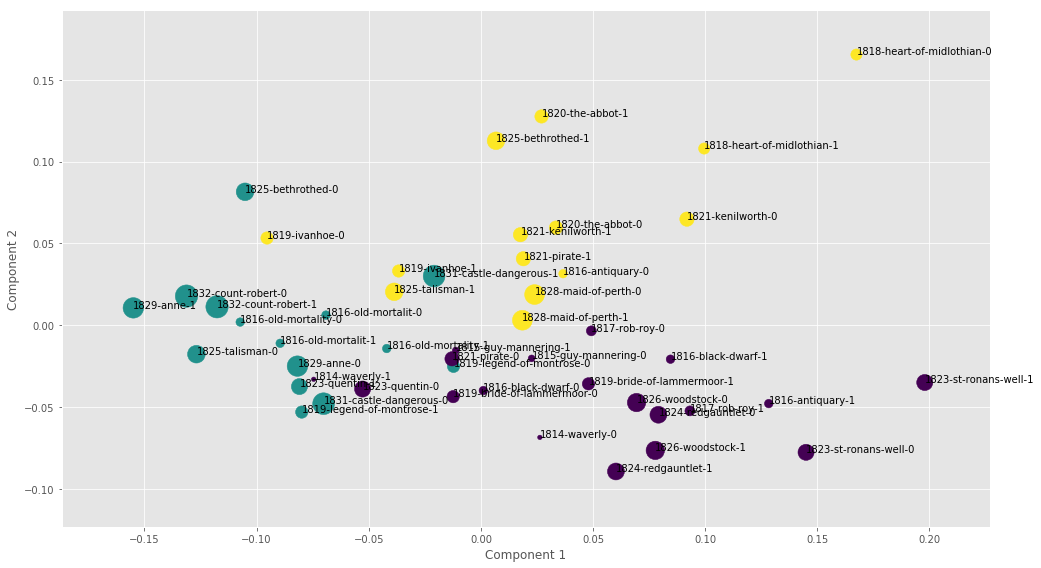

In [86]:
doAnalysis('scott')

# Mary Augusta Ward

Lateness: 
0: -0.12318663531608429 1: -0.13084701649373232 2: -0.13524341230582201 3: -0.13005629954175738 4: -0.12371293437161177 5: -0.14933511058006566 6: -0.12574167436671252 7: -0.11547664743197551 8: -0.12196363889689567 9: -0.12021755589949049 
Periodicity: Adjusted rand score, BGM:  0.044697067562330495
Lateness:  -0.1202260133903372
None
Average lateness:  -0.12757351019339583
Average periodicities:  0.10207990080467685


,0,1,2,3,4,distance,bgm,initCats,pubDate
1881-milly-0,0.394709,-0.069420,-0.012957,0.033956,-0.021824,0.403004,2,0,1881
1881-milly-1,0.356177,0.002562,-0.007104,0.008075,-0.000094,0.356348,2,0,1881
1915-success-1,0.039696,0.184465,0.072273,-0.108437,-0.092235,0.247169,0,2,1915
1900-eleanor-1,-0.045048,0.116658,0.138207,0.119281,-0.025101,0.222705,1,1,1900
1916-connie-1,-0.042200,-0.167217,0.104199,-0.008589,0.031402,0.204107,1,2,1916
1917-missing-1,-0.006549,0.129763,-0.036116,-0.060692,0.125445,0.193922,0,2,1917
1915-success-0,-0.024032,0.104270,-0.039156,-0.110038,-0.078938,0.176982,0,2,1915
1908-diana-0,-0.069263,-0.124445,-0.057498,-0.008978,-0.046857,0.160829,1,1,1908
1903-lady-rose-0,-0.056825,0.109002,0.085353,0.042184,0.000288,0.155483,1,1,1903
1888-robert-0,-0.058794,0.064755,-0.122724,0.018911,0.007497,0.152069,1,0,1888


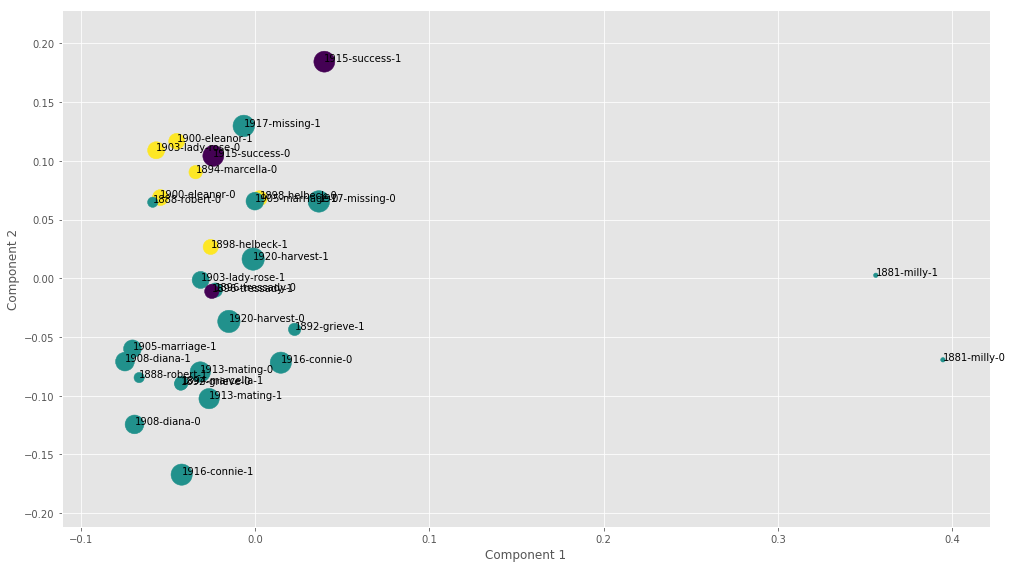

In [87]:
doAnalysis('ward')

Lateness: 
0: 0.12225453477624837 1: 0.008369337041353037 2: -0.01187945171179057 3: -0.015486988035405408 4: 0.10102216144787116 5: 0.10231204467240414 6: 0.005069137251606223 7: 0.10748457404821586 8: 0.1240125062221758 9: 0.07993744427668854 
Periodicity: Adjusted rand score, BGM:  0.12890105592491202
Lateness:  0.07994914326546208
None
Average lateness:  0.06231048135758064
Average periodicities:  0.15454462646595984


,0,1,2,3,4,distance,bgm,initCats,pubDate
1856-the-shaving-of-shagpat-0,-0.233162,0.254750,0.062877,-0.044735,0.064552,0.359700,2,0,1856
1856-the-shaving-of-shagpat-1,-0.224598,0.256635,0.041440,-0.032772,0.058577,0.350041,2,0,1856
1864-emilia-in-england-0,0.301388,0.067987,0.133887,0.004050,-0.040749,0.339205,0,0,1864
1857-farina-1,-0.208312,0.096726,-0.138700,0.022751,-0.082401,0.281594,2,0,1857
1910-celt-and-saxon-0,-0.223747,-0.141487,-0.067124,0.022203,0.039145,0.276789,1,2,1910
1865-rhoda-fleming-1,0.179658,0.054138,-0.057303,0.119134,-0.002848,0.229549,1,0,1865
1859-the-ordeal-of-richard-feverel-1,0.113358,0.025962,-0.150595,-0.107748,-0.054247,0.225289,0,0,1859
1857-farina-0,-0.153652,0.135503,-0.081330,0.034075,-0.024491,0.224378,2,0,1857
1859-the-ordeal-of-richard-feverel-0,0.155377,0.098885,-0.071913,-0.087587,-0.037893,0.219543,0,0,1859
1861-evan-harrington-1,0.182817,0.086381,-0.024228,0.028008,-0.011036,0.205857,0,0,1861


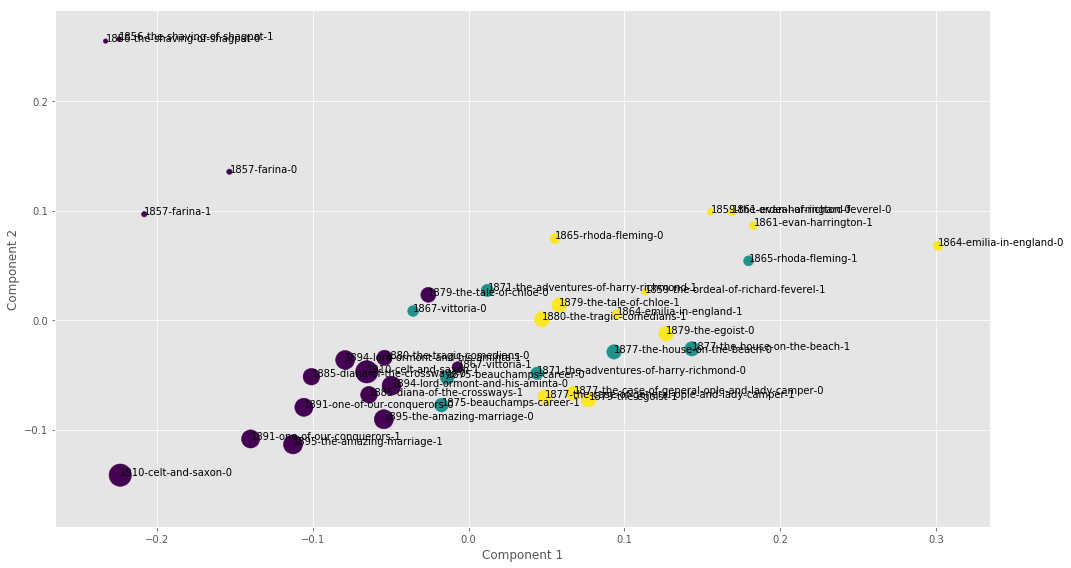

In [88]:
doAnalysis('meredith')

Lateness: 
0: 0.08483177344457397 1: 0.11997699984663533 2: 0.1408702466078087 3: 0.053456116270749865 4: 0.1127099363272568 5: 0.06288649738662659 6: 0.08469834735297317 7: 0.07868673413887915 8: 0.08116703026422219 9: 0.07056143679615282 
Periodicity: Adjusted rand score, BGM:  0.3579973416038989
Lateness:  0.07056129141584884
None
Average lateness:  0.08898476958224558
Average periodicities:  0.1521841503144084


,0,1,2,3,4,distance,bgm,initCats,pubDate
1935-lucy-gayheart-1,0.250039,-0.144091,0.068410,0.085871,0.048458,0.312544,1,2,1935
1927-death-comes-for-the-archbishop-1,-0.226020,-0.105591,-0.042483,0.003410,0.017192,0.253666,2,1,1927
1913-o-pioneers-0,0.061414,0.161818,0.011421,-0.080190,0.140085,0.236942,0,0,1913
1927-death-comes-for-the-archbishop-0,-0.193185,-0.103814,-0.064228,0.024633,0.028904,0.231658,2,1,1927
1935-lucy-gayheart-0,0.154336,-0.105795,0.064665,0.081834,0.061310,0.222821,1,2,1935
1922-one-of-ours-1,-0.213736,0.032300,-0.000876,-0.017265,0.037918,0.220143,2,1,1922
1918-my-ántonia-1,0.137857,-0.001011,-0.114539,-0.111646,-0.004965,0.211221,1,0,1918
1926-my-mortal-enemy-1,0.161935,-0.019793,-0.121313,-0.019379,-0.052332,0.210822,1,1,1926
1931-shadows-on-the-rock-1,-0.135763,-0.116002,-0.008871,-0.028288,-0.014675,0.181610,2,1,1931
1915-the-song-of-the-lark-0,0.135579,0.038299,0.051808,0.080661,-0.060301,0.180762,1,0,1915


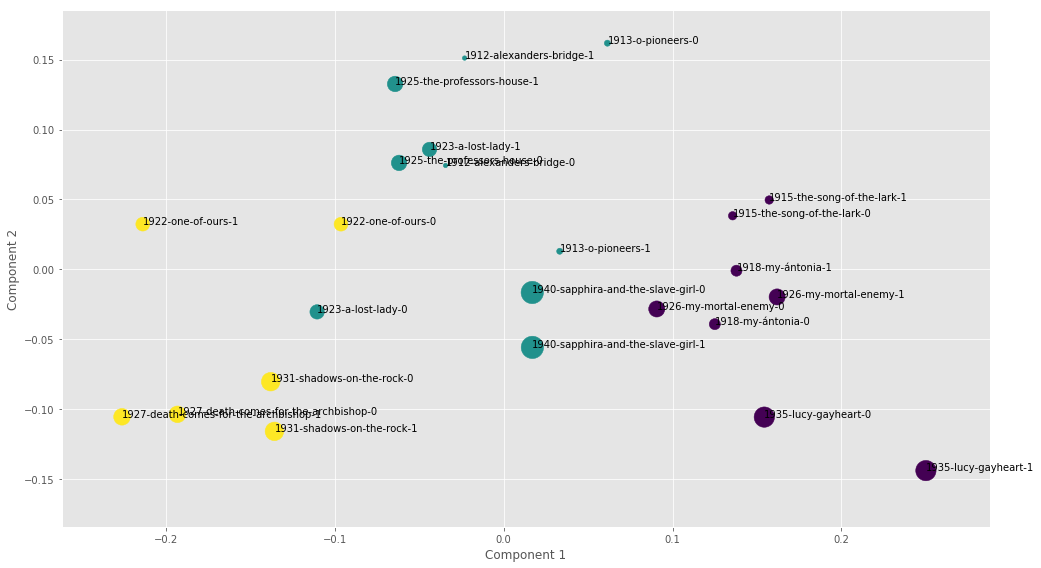

In [89]:
doAnalysis('cather')

Lateness: 
0: -0.008843296122346134 1: -0.02788698397277642 2: -0.03198046557713702 3: -0.040096699548148 4: -0.024442233551527845 5: -0.03080819587640353 6: -0.009379803182200774 7: -0.01213933476786648 8: -0.0034170826073519206 9: -0.0077922099600809674 
Periodicity: Adjusted rand score, BGM:  0.014365522745410992
Lateness:  -0.007792053519897271
None
Average lateness:  -0.019678630218306452
Average periodicities:  0.18729619882293008


,0,1,2,3,4,distance,bgm,initCats,pubDate
1902-grand-babylon-1,0.196788,-0.099939,0.004868,-0.081713,0.004183,0.235439,2,0,1902
1902-grand-babylon-0,0.180026,-0.066535,-0.015030,-0.096394,-0.003528,0.215329,2,0,1902
1928-strange-vanguard-0,0.125749,0.056072,-0.076167,0.112383,-0.074787,0.207320,1,2,1928
1910-clayhanger-0,-0.117540,-0.125942,-0.052256,-0.026181,-0.051858,0.189163,0,1,1910
1928-strange-vanguard-1,0.118342,-0.026276,-0.033561,0.119683,-0.047586,0.180028,1,2,1928
1910-clayhanger-1,-0.117789,-0.116864,-0.049375,-0.008024,-0.045807,0.179254,0,1,1910
1923-riceyman-1,-0.051067,0.144063,-0.068602,-0.041179,0.007721,0.172695,0,2,1923
1911-card-1,0.006268,-0.065065,0.133844,0.051412,0.033062,0.161007,0,1,1911
1902-anna-1,0.051975,0.118479,0.085990,-0.015212,-0.023238,0.157811,0,0,1902
1929-accident-1,-0.028566,-0.017104,-0.091306,0.031109,0.113755,0.152818,1,2,1929


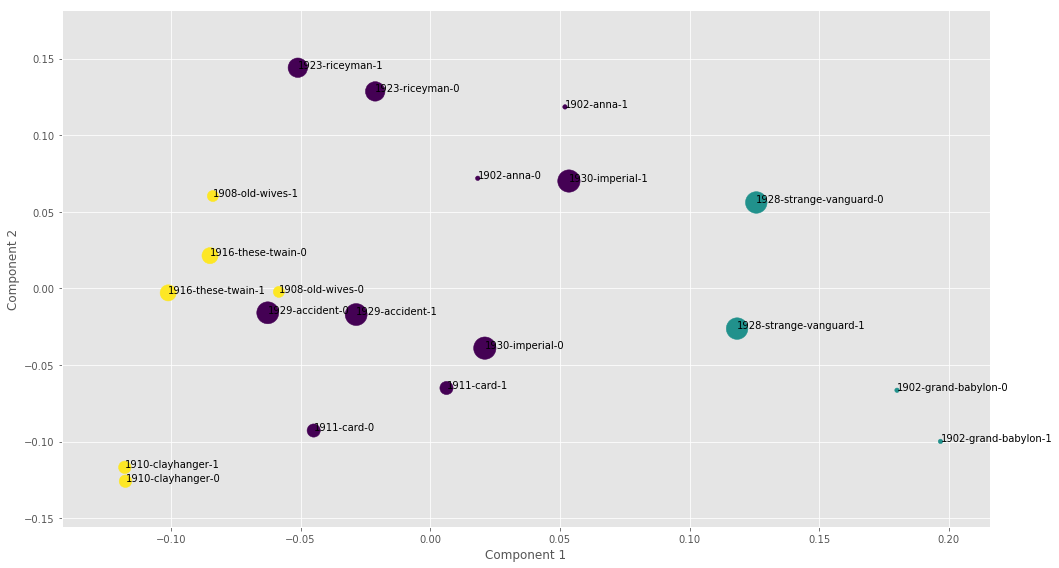

In [90]:
doAnalysis('bennett')

Lateness: 
0: 0.08668542484912548 1: 0.10473411464609397 2: 0.1160071225104986 3: 0.0700498264010306 4: 0.08719701401908377 5: 0.08390299231910064 6: 0.09390405650842686 7: 0.08858954962365168 8: 0.07276698881738108 9: 0.08893427576307283 
Periodicity: Adjusted rand score, BGM:  0.03993668574211615
Lateness:  0.08893434275720738
None
Average lateness:  0.08927678212472301
Average periodicities:  0.0249348645689915


,0,1,2,3,4,distance,bgm,initCats,pubDate
1931-waves-0,-0.329187,-0.039928,-0.120263,0.164565,0.042245,0.391519,0,1,1931
1927-to-the-lighthouse-1,0.331291,0.029375,-0.052094,0.030114,0.155829,0.372182,2,1,1927
1931-waves-1,-0.303402,-0.106611,-0.158350,0.098038,-0.004060,0.371647,0,1,1931
1921-monday-or-tuesday-1,-0.299196,0.000173,0.035765,-0.075270,-0.012766,0.310847,0,0,1921
1937-years-1,0.194574,0.226913,-0.055639,0.043895,-0.043009,0.310195,1,2,1937
1937-years-0,0.181388,0.197769,0.025195,0.105745,-0.083094,0.301223,1,2,1937
1928-orlando-1,-0.081104,-0.191427,0.180305,0.024151,-0.017373,0.276798,0,1,1928
1919-night-and-day-0,0.196357,-0.123358,-0.072239,-0.092657,0.047814,0.264316,2,0,1919
1941-between-the-acts-0,-0.055276,0.214494,0.083259,-0.003849,0.051841,0.242275,0,2,1941
1922-jacobs-room-0,-0.189810,0.089989,0.104553,-0.057458,-0.000658,0.241576,0,1,1922


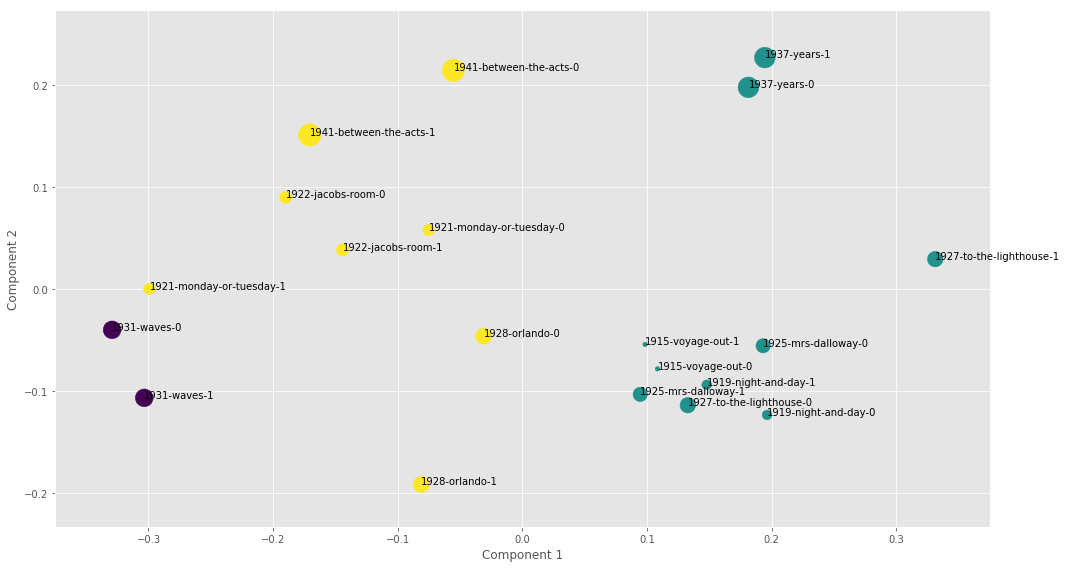

In [8]:
doAnalysis('woolf')

Lateness: 
0: 0.003505306926989374 1: -0.01474684086309297 2: -0.01610724580107302 3: -0.01713627505547366 4: -0.027014530774937248 5: -0.014253555059606446 6: -0.008852169942315927 7: -0.008453025139880457 8: -0.0220583860589217 9: 0.00010263951946687389 
Periodicity: Adjusted rand score, BGM:  0.13065795613625758
Lateness:  0.00010278458661806822
None
Average lateness:  -0.012501254530432198
Average periodicities:  0.1255876588594826


,0,1,2,3,4,distance,bgm,initCats,pubDate
1855-warden-0,0.241283,-0.032247,-0.009624,0.028547,-0.015138,0.245752,1,0,1855
1855-warden-1,0.208513,-0.028719,-0.002756,0.021344,-0.017610,0.212311,1,0,1855
1884-old-man-0,-0.140549,-0.032501,0.097467,0.031875,-0.036036,0.180623,2,2,1884
1884-old-man-1,-0.119919,-0.091876,0.070419,0.004905,-0.059777,0.177138,2,2,1884
1857-barchester-0,0.125208,0.085006,0.056613,0.029230,-0.055478,0.173321,1,0,1857
1861-framley-0,-0.056965,0.135920,-0.071688,0.043830,0.026641,0.171724,2,0,1861
1858-doctor-thorne-1,-0.079372,0.005301,0.039463,0.121321,0.081614,0.171070,2,0,1858
1865-can-you-forgive-1,-0.114089,0.049731,-0.053544,-0.025469,-0.030287,0.141147,2,1,1865
1869-phineas-1,-0.063465,-0.064479,-0.081572,-0.052317,-0.002464,0.132599,0,1,1869
1883-landleaguers-0,0.054221,0.014435,0.048028,-0.100409,0.003383,0.124693,1,2,1883


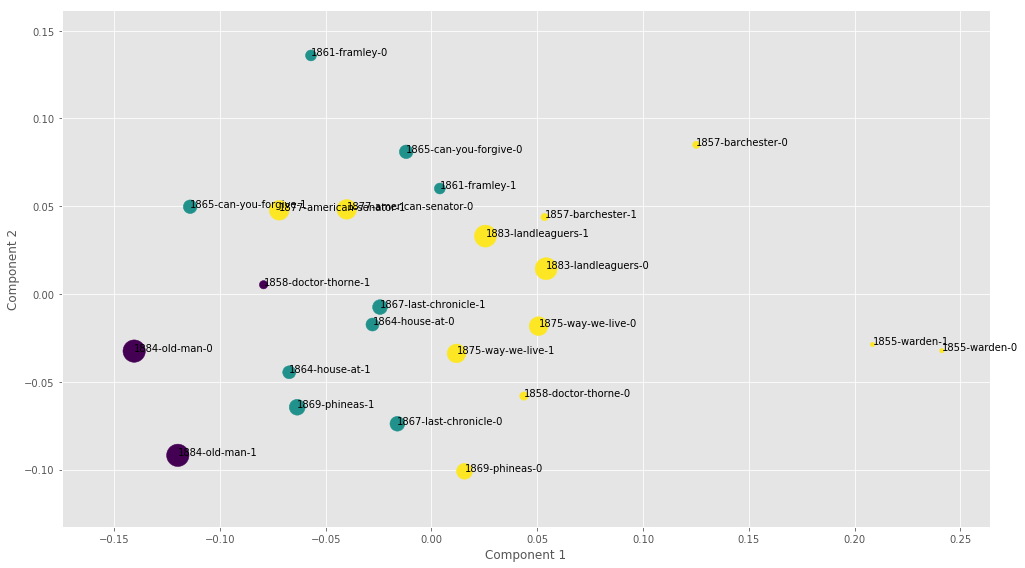

In [92]:
doAnalysis('trollope')

In [93]:
df = pd.DataFrame(authorTable)
df

,proust,dickens,conrad,genet,james,mann,scott,ward,meredith,cather,bennett,woolf,trollope
mean lateness,-0.086692,0.008225,0.011183,0.152592,0.061120,0.197111,0.024777,-0.127574,0.062310,0.088985,-0.019679,0.018383,-0.012501
mean periodicity,0.042890,0.228223,0.092724,0.136048,0.285835,0.077037,0.076355,0.102080,0.154545,0.152184,0.187296,0.007085,0.125588


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5e98dec50>,
      dtype=object)

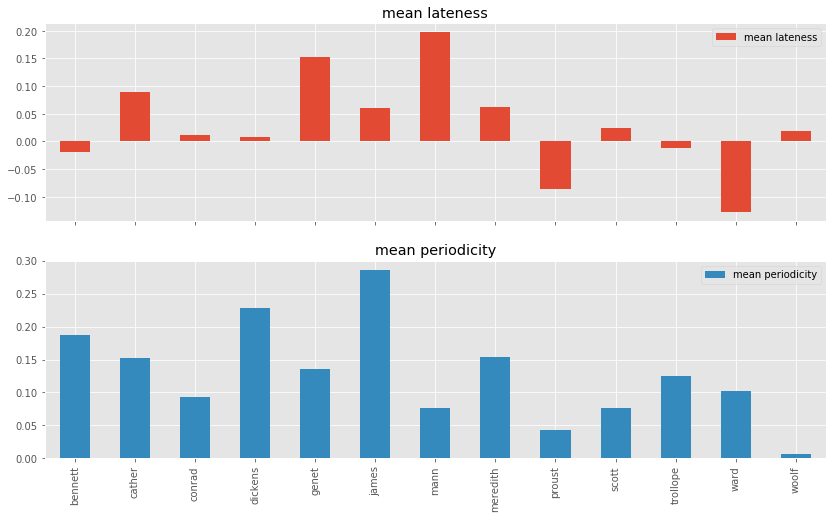

In [94]:
df.sort_index(axis=1).T.plot(kind='bar', subplots=True)

In [95]:
df.mean(axis=1)

mean lateness       0.029095
mean periodicity    0.128299
dtype: float64